In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as stats
from statsmodels.tsa.stattools import acf
from scipy.special import gamma

In [2]:
dir = "figures"
os.makedirs(dir, exist_ok=True)

In [3]:
### Data loading

def load_data(filepath):

    try:
        df = pd.read_csv(filepath)
        # Check for standard Oxford Man columns
        if 'Symbol' in df.columns and 'rv5' in df.columns:
            # Clean up dates
            df['Date'] = pd.to_datetime(df['Unnamed: 0'] if 'Unnamed: 0' in df.columns else df.index, utc=True)
            df.set_index('Date', inplace=True)
            return df
        else:
            print("Columns 'Symbol' and 'rv5' exist")
            return None
    except FileNotFoundError:
        print(f"File {filepath} not found")

DATA_FILE = 'data/oxfordmanrealizedvolatilityindices.csv' 
full_data = load_data(DATA_FILE)

In [4]:
full_data.head(6)

,Unnamed: 0,Symbol,rv5_ss,close_time,rsv_ss,open_time,rk_parzen,rv5,rv10_ss,bv,close_price,rv10,open_price,rk_twoscale,medrv,bv_ss,open_to_close,nobs,rsv,rk_th2
Date,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00+00:00,2000-01-03 00:00:00+00:00,.AEX,0.000130,163015.0,0.000046,90101.0,0.000179,0.000130,0.000178,0.000100,675.44,0.000178,675.67,0.000103,0.000050,0.000100,-0.000340,1795.0,0.000046,0.000102
2000-01-04 00:00:00+00:00,2000-01-04 00:00:00+00:00,.AEX,0.000201,163016.0,0.000147,90416.0,0.000423,0.000201,0.000261,0.000207,642.25,0.000261,664.20,0.000199,0.000075,0.000207,-0.033606,1785.0,0.000147,0.000201
2000-01-05 00:00:00+00:00,2000-01-05 00:00:00+00:00,.AEX,0.000491,163016.0,0.000328,90016.0,0.000324,0.000491,0.000714,0.000361,632.31,0.000714,633.37,0.000325,0.000166,0.000361,-0.001675,1801.0,0.000328,0.000345
2000-01-06 00:00:00+00:00,2000-01-06 00:00:00+00:00,.AEX,0.000225,163002.0,0.000116,90016.0,0.000219,0.000225,0.000182,0.000258,624.21,0.000182,632.46,0.000218,0.000152,0.000258,-0.013130,1799.0,0.000116,0.000221
2000-01-07 00:00:00+00:00,2000-01-07 00:00:00+00:00,.AEX,0.000138,163016.0,0.000048,90046.0,0.000155,0.000138,0.000157,0.000130,644.86,0.000157,628.93,0.000126,0.000039,0.000130,0.025013,1798.0,0.000048,0.000123
2000-01-10 00:00:00+00:00,2000-01-10 00:00:00+00:00,.AEX,0.000109,163017.0,0.000062,90146.0,0.000086,0.000109,0.000126,0.000089,655.14,0.000126,651.82,0.000074,0.000032,0.000089,0.005081,1794.0,0.000062,0.000073


In [5]:
# Filter for SPX and get Realized Variance (using rv5)
spx_data = full_data[full_data['Symbol'] == '.SPX'].copy()
# rv_col = 'rk_th2' 
rv_col = 'rv5'
spx_rk = spx_data[rv_col]

Text(0.5, 0, 'Date')

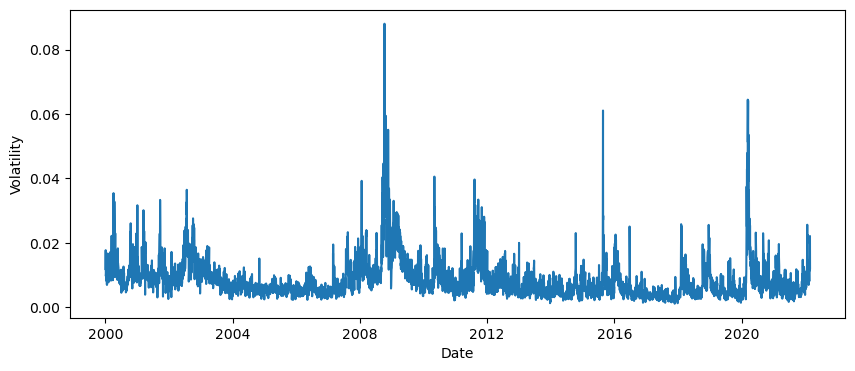

In [6]:
plt.figure(figsize=(10,4))
plt.plot(np.sqrt(spx_rk))
plt.ylabel('Volatility')
plt.xlabel('Date')

### RFSV Model 

In [7]:
def calculate_mq_delta(series, q, lags):
    """
    Calculates m(q, Delta) = mean( |log(sigma_{t+Delta}) - log(sigma_t)|^q )
    """
    # Volatility is sqrt(Variance)
    log_sig = np.log(np.sqrt(series)) # log(volatility) # volatility = sqrt(Realised Variance)
    
    m_q = []
    for lag in lags:
        diffs = log_sig.diff(lag).dropna()
        mean_moment = np.mean(np.abs(diffs)**q)  # averaging over time t
        m_q.append(mean_moment)
    return np.array(m_q)


### RFSV FORECASTING

def c_tilde(h):
    return gamma(1.5 - h) / (gamma(h + 0.5) * gamma(2 - 2*h))

def forecast_rfsv(rv_series, H, nu, delta=1, n_lags=500):

    log_rv = np.log(rv_series).values
    n = len(log_rv)
    forecasts = np.full(n, np.nan)
    
    # compute weights
    ## 1 / ((j + 0.5 + delta) * (j + 0.5)^(H + 0.5))
    j = np.arange(n_lags) # j >> lags
    weights = 1.0 / ((j + 0.5 + delta) * (j + 0.5)**(H + 0.5))
    
    # Normalize weights
    weights = weights / np.sum(weights)
    
    # Generate Forecasts
    # We start from index = n_lags
    for i in range(n_lags, n - delta):  # delta mean how many lags aheade forcast
        # Extract history and reverse it so the >> [yesterday, the day before, ...]
        history = log_rv[i - n_lags : i][::-1]

        local_mean = np.mean(history)
        # centered_hist = history - local_mean
        
        # Forecast Log Vol
        log_forecast = np.dot(weights, history)
        # log_forecast = np.dot(weights, centered_hist)
        
        correction = 2 * nu**2 * c_tilde(H) * (delta**(2*H))
        
        forecasts[i + delta] = np.exp(log_forecast + correction)
        # forecasts[i + delta] =  log_forecast + local_mean
        
    return pd.Series(forecasts, index=rv_series.index)


lags = np.arange(1, 101)
m2_vals = calculate_mq_delta(spx_rk, 2.0, lags) # q = 2.0
slope_2, intercept_2, _, _, _ = stats.linregress(np.log(lags), np.log(m2_vals))
slope_h = slope_2/2.0
nu_est = np.sqrt(np.exp(intercept_2))
print(f"Estimated nu (vol of vol): {nu_est:.4f}")

# Run Forecast (1 day ahead)
delta_days = 1
rv_pred = forecast_rfsv(spx_rk, H=slope_h, nu=nu_est, delta=delta_days, n_lags=500)


Estimated nu (vol of vol): 0.3542


In [8]:
rv_pred

Date
2000-01-03 00:00:00+00:00         NaN
2000-01-04 00:00:00+00:00         NaN
2000-01-05 00:00:00+00:00         NaN
2000-01-06 00:00:00+00:00         NaN
2000-01-07 00:00:00+00:00         NaN
                               ...   
2022-02-18 00:00:00+00:00    0.000101
2022-02-22 00:00:00+00:00    0.000091
2022-02-23 00:00:00+00:00    0.000122
2022-02-24 00:00:00+00:00    0.000166
2022-02-25 00:00:00+00:00    0.000145
Length: 5552, dtype: float64

Text(0.5, 0, 'Date')

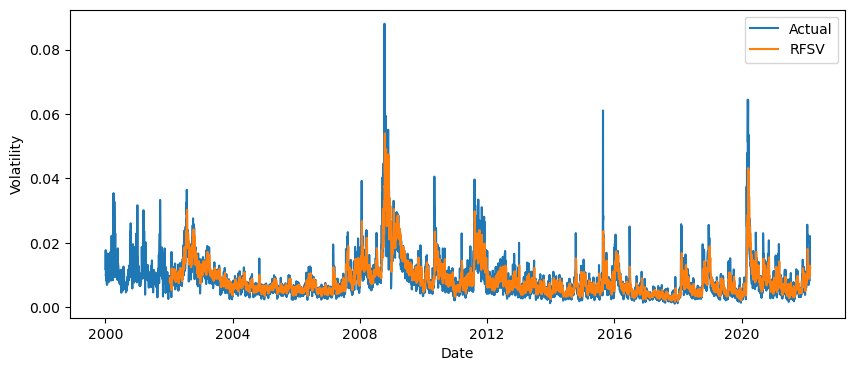

In [9]:
plt.figure(figsize=(10,4))
plt.plot(np.sqrt(spx_rk), label='Actual')
plt.plot(np.sqrt(rv_pred), label="RFSV")
# plt.plot(np.sqrt(np.exp(rv_pred)), label="RFSV")
# plt.yscale("log")
plt.legend()
plt.ylabel('Volatility')
plt.xlabel('Date')

### AR model

\begin{equation}
\widehat{\log(\sigma_{t+\Delta}^2)}
=
K_0^{\Delta}
+
\sum_{i=0}^{p}
C_i^{\Delta}\,
\log(\sigma_{t-i}^2).
\end{equation}


In [10]:
from sklearn.linear_model import LinearRegression

def forecast_ar(series, p, horizon=1, window_size=500):
    """Rolling AR(p) forecast for log-variance."""
    vals = series.values
    n = len(vals)
    preds = np.full(n, np.nan)
    
    # Build Lag Matrix
    X_lags = []
    for i in range(p):
        X_lags.append(pd.Series(vals).shift(i).values)
    X = np.column_stack(X_lags)
    
    for t in range(window_size + p, n - horizon):
        
        curr_X_train = X[t-window_size : t]
        curr_y_train = vals[t-window_size+horizon : t+horizon] # target is one step aheade

        # print(curr_X_train.shape, curr_y_train.shape)
    
        # Simple Linear Regression (OLS)
        try:
            model = LinearRegression()
            model.fit(curr_X_train, curr_y_train)
            
            # Predict
            current_features = X[t].reshape(1, -1)
            preds[t + horizon] = model.predict(current_features)[0]
        except:
            pass
            
    return pd.Series(preds, index=series.index)

In [11]:
log_rv = np.log(spx_rk)
pred_ar5 = forecast_ar(log_rv, p=5, horizon=1, window_size=500)

In [12]:
pred_ar5.head(257)

Date
2000-01-03 00:00:00+00:00   NaN
2000-01-04 00:00:00+00:00   NaN
2000-01-05 00:00:00+00:00   NaN
2000-01-06 00:00:00+00:00   NaN
2000-01-07 00:00:00+00:00   NaN
                             ..
2001-01-03 00:00:00+00:00   NaN
2001-01-04 00:00:00+00:00   NaN
2001-01-05 00:00:00+00:00   NaN
2001-01-08 00:00:00+00:00   NaN
2001-01-09 00:00:00+00:00   NaN
Length: 257, dtype: float64

Text(0.5, 0, 'Date')

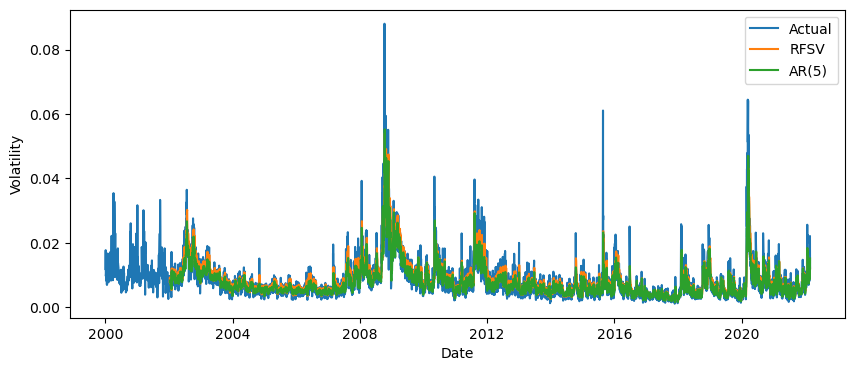

In [13]:
plt.figure(figsize=(10,4))
plt.plot(np.sqrt(spx_rk), label='Actual')
plt.plot(np.sqrt(rv_pred), label="RFSV")
plt.plot(np.sqrt(np.exp(pred_ar5)), label="AR(5)")
# plt.yscale("log")
plt.legend()
plt.ylabel('Volatility')
plt.xlabel('Date')

### HAR Model

\begin{equation}
\widehat{\log(\sigma_{t+\Delta}^2)}
=
K_0^{\Delta}
+
C_0^{\Delta}\,\log(\sigma_t^2)
+
C_5^{\Delta}\,
\frac{1}{5}
\sum_{i=0}^{4}
\log(\sigma_{t-i}^2)
+
C_{20}^{\Delta}\,
\frac{1}{20}
\sum_{i=0}^{19}
\log(\sigma_{t-i}^2).
\end{equation}

In [14]:
def forecast_har(series, horizon=1, window_size=500):
   
    """Rolling HAR forecast for log-variance."""
    vals = series.values
    n = len(vals)
    preds = np.full(n, np.nan)
    
    # Features: Daily, Weekly (5), Monthly (20)
    rv_d = vals
    rv_w = pd.Series(vals).rolling(5).mean().values
    rv_m = pd.Series(vals).rolling(20).mean().values
    
    X = np.column_stack([rv_d, rv_w, rv_m])
    
    start_idx = 20
    for t in range(start_idx + window_size, n - horizon):
        curr_X_train = X[t-window_size : t]
        curr_y_train = vals[t-window_size+horizon : t+horizon]
        
        try:
            model = LinearRegression()
            model.fit(curr_X_train, curr_y_train)
            preds[t + horizon] = model.predict(X[t].reshape(1, -1))[0]
        except:
            pass

    return pd.Series(preds, index=series.index)

In [15]:
pred_har = forecast_har(log_rv, horizon=1, window_size=500)

Text(0.5, 0, 'Date')

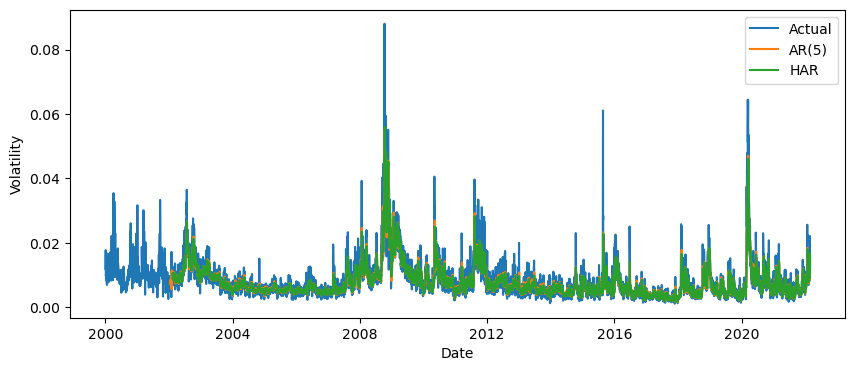

In [16]:
plt.figure(figsize=(10,4))
plt.plot(np.sqrt(spx_rk), label='Actual')
plt.plot(np.sqrt(np.exp(pred_ar5)), label="AR(5)")
plt.plot(np.sqrt(np.exp(pred_har)), label="HAR")
# plt.yscale("log")
plt.legend()
plt.ylabel('Volatility')
plt.xlabel('Date')

## P ratio = MSE predictor / Mean predictor

\begin{equation}
P
=
\frac{
\displaystyle
\sum_{k=500}^{N-\Delta}
\left(
\log(\sigma_{k+\Delta}^2)
-
\widehat{\log(\sigma_{k+\Delta}^2)}
\right)^2
}{
\displaystyle
\sum_{k=500}^{N-\Delta}
\left(
\log(\sigma_{k+\Delta}^2)
-
\mathbb{E}\!\left[\log(\sigma_{t+\Delta}^2)\right]
\right)^2
}.
\end{equation}

In [17]:
def calculate_P_ratio(predicted_log_var, actual_log_var, train_window=500, delta=1):

    # Align series ## remove the delta part
    common_idx = predicted_log_var.dropna().index.intersection(actual_log_var.dropna().index)
    
    # We only evaluate after the initial training window (approx 500 days)
    if len(common_idx) < train_window:
        return np.nan
        
    y_pred = predicted_log_var[common_idx]
    y_true = actual_log_var[common_idx]
    
    # train_window=k=500 (in paper)
    eval_y_true = y_true.iloc[train_window:]
    eval_y_pred = y_pred.iloc[train_window:]
    
    # Numerator: MSE of predictor
    numerator = np.sum((eval_y_true - eval_y_pred)**2)
    
    # Denominator: Variance of log-variance (Mean prediction)
    # E[log(sigma^2)] is empirical mean over whole period for true dat
    mean_log_var = y_true.mean() 
    denominator = np.sum((eval_y_true - mean_log_var)**2)
    
    return numerator / denominator

### Compare performance for different forecasts

In [18]:

if full_data is not None:
    results = []
    
    indices = ['.SPX', '.FTSE', '.N225', '.GDAXI', '.FCHI']
    index_names = ['SPX2', 'FTSE2', 'N2252', 'GDAXI2', 'FCHI2']
    
    horizons = [1, 5, 20]
    
    print(f"{'Index':<15} {'AR(5)':<10} {'AR(10)':<10} {'HAR(3)':<10} {'RFSV':<10}")
    print("-" * 60)

    for symbol, name in zip(indices, index_names):
        # Prepare Data
        asset_data = full_data[full_data['Symbol'] == symbol].copy()
        if asset_data.empty: continue
        
        rv_col = 'rk' if 'rk' in asset_data.columns else 'rv5'
        # Variance
        rv = asset_data[rv_col].replace(0, np.nan).dropna()
        # Log Variance
        log_rv = np.log(rv)
        
        lags = np.arange(1, 101)
        m2_vals = calculate_mq_delta(rv, 2.0, lags) # q = 2.0
        slope_2, intercept_2, _, _, _ = stats.linregress(np.log(lags), np.log(m2_vals))
        slope_h = slope_2/2.0
        nu_est = np.sqrt(np.exp(intercept_2))

        print(symbol, f"Estimated nu : {nu_est:.4f}", f"Estimated H: {slope_h:.4f}")
            
        for delta in horizons:
            # 1. AR(5)
            pred_ar5 = forecast_ar(log_rv, p=5, horizon=delta, window_size=250)
            p_ar5 = calculate_P_ratio(pred_ar5, log_rv, train_window=250, delta=delta)
            
            # 2. AR(10)
            pred_ar10 = forecast_ar(log_rv, p=10, horizon=delta, window_size=250)
            p_ar10 = calculate_P_ratio(pred_ar10, log_rv, train_window=250, delta=delta)
            
            # 3. HAR(3)
            pred_har = forecast_har(log_rv, horizon=delta, window_size=250)
            p_har = calculate_P_ratio(pred_har, log_rv, train_window=250, delta=delta)
            
            # 4. RFSV
            pred_rfsv = forecast_rfsv(rv, H=slope_h, nu=nu_est, delta=delta, n_lags=250)
            p_rfsv = calculate_P_ratio(np.log(pred_rfsv), log_rv, delta=delta)
            # p_rfsv = calculate_P_ratio(pred_rfsv, log_rv, train_window=250, delta=delta)
            
            # Store Row
            row_label = f"{name}.rv D={delta}"
            results.append({
                'Name': row_label,
                'AR(5)': p_ar5,
                'AR(10)': p_ar10,
                'HAR(3)': p_har,
                'RFSV': p_rfsv
            })

            print(f"{row_label:<15} {p_ar5:.3f}      {p_ar10:.3f}      {p_har:.3f}    {p_rfsv:.3f}")

else:
    print("No data available.")

Index           AR(5)      AR(10)     HAR(3)     RFSV      
------------------------------------------------------------
.SPX Estimated nu : 0.3542 Estimated H: 0.1426
SPX2.rv D=1     0.282      0.288      0.281    0.371
SPX2.rv D=5     0.456      0.458      0.446    0.548
SPX2.rv D=20    0.642      0.656      0.635    0.821
.FTSE Estimated nu : 0.3486 Estimated H: 0.1114
FTSE2.rv D=1    0.355      0.359      0.350    0.431
FTSE2.rv D=5    0.464      0.470      0.457    0.537
FTSE2.rv D=20   0.631      0.641      0.616    0.747
.N225 Estimated nu : 0.3291 Estimated H: 0.1181
N2252.rv D=1    0.365      0.370      0.363    0.458
N2252.rv D=5    0.537      0.539      0.528    0.612
N2252.rv D=20   0.727      0.745      0.722    0.882
.GDAXI Estimated nu : 0.3077 Estimated H: 0.1332
GDAXI2.rv D=1   0.272      0.276      0.270    0.359
GDAXI2.rv D=5   0.395      0.400      0.388    0.487
GDAXI2.rv D=20  0.567      0.575      0.553    0.723
.FCHI Estimated nu : 0.3042 Estimated H: 0.1307
FCH